<a href="https://colab.research.google.com/github/belom-nlp/micro_topic_modelling/blob/main/notebooks/MTM_number_of_clusters_influencing_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we register correlations between number of topics and metric values.

In [ ]:
from IPython.display import clear_output

In [ ]:
! pip install sentence_transformers
clear_output()

In [ ]:
#importing necessary libraries
from collections import Counter
import numpy as np
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import nltk

from transformers import AutoTokenizer
from transformers import BertModel
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN, DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from model import MicroTopicModeller

In [ ]:
with open('text_data/iran_1.txt', 'r') as file:
  lines = file.read()

#Metrics

See MTM_on_train_datasets.ipynb notebook for the explanation.

In [ ]:
! git clone https://github.com/christianrfg/tm_metrics.git

Cloning into 'tm_metrics'...
remote: Enumerating objects: 79, done.
remote: Total 79 (delta 0), reused 0 (delta 0), pack-reused 79
Receiving objects: 100% (79/79), 1.19 MiB | 6.58 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
!sed -i 's/cv_model.get_feature_names()/cv_model.get_feature_names_out()/' tm_metrics/tm_metrics/feature_extraction/text.py

In [ ]:
!pip install -U /content/tm_metrics

Processing ./tm_metrics
  Preparing metadata (setup.py) ... done
  Created wheel for tm-metrics: filename=tm_metrics-0.1-py3-none-any.whl size=8217 sha256=9796b9726a938d20db2c65d9002eac484b5606762aba97067c7660ea8131b19f
  Stored in directory: /tmp/pip-ephem-wheel-cache-1gmblheb/wheels/88/73/88/e84eb7e10e9fc6ecb2f0e636d851f394cd8789c1ed40d09cc7
Successfully built tm-metrics
  Attempting uninstall: tm-metrics
    Found existing installation: tm-metrics 0.1
    Uninstalling tm-metrics-0.1:
      Successfully uninstalled tm-metrics-0.1


In [ ]:
def pmi(topic_words, word_frequency, word_frequency_in_documents, n_docs, normalise=False):
    """PMI/NPMI topic quality metric for a topic.

    Calculates the PMI/NPMI topic quality metric for one individual topic based on the topic words.

    Args:
        topic_words: list
            Words that compose one individual topic.
        word_frequency: dict
            Frequency of each word in corpus.
        word_frequency_in_documents: dict
            Frequency of each word for each document in corpus.
        n_docs: int
            Number of documents in the corpus.
        normalise: bool, default=False
            Where to normalise (NPMI) or not (PMI).

    Returns:
        pmi: float
            Resultant PMI metric value for the topic.
        npmi: float
            Resultant NPMI metric value for the topic.
    """
    n_top = len(topic_words)
    pmi = 0.0
    npmi = 0.0

    for j in range(1, n_top):
        for i in range(0, j):
            ti = topic_words[i]
            tj = topic_words[j]

            c_i = word_frequency[ti]
            c_j = word_frequency[tj]
            c_i_and_j = len(word_frequency_in_documents[ti].intersection(word_frequency_in_documents[tj]))

            dividend = (c_i_and_j + 1.0) / float(n_docs)
            divisor = ((c_i * c_j) / float(n_docs) ** 2)
            pmi += max([np.log(dividend / divisor), 0])

            npmi += -1.0 * np.log((c_i_and_j + 0.01) / float(n_docs))

    if npmi != 0:
        npmi = pmi / npmi

    if normalise:
        return npmi
    else:
        return pmi

In [ ]:
from tm_metrics.feature_extraction import get_tfidf_matrices, get_vocabulary, get_word_frequencies
from tm_metrics.metrics import coherence, tfidf_coherence, lcp, pmi, topic_w2v

In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models import Word2Vec

In [ ]:
def prepare_data_for_metrics(data):
  n_features = int(len(data)/2)
  w2v_data_samples = [str.split(x) for x in data]
  model = Word2Vec(w2v_data_samples, vector_size=100, window=5, min_count=1, workers=4)
  word_embedding = model.wv
  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=1000)
  tfidf = tfidf_vectorizer.fit_transform(data)
  tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
  tfidf_matrix, tfidf_matrix_transpose = get_tfidf_matrices(data)
  vocabulary = get_vocabulary(data)
  word_frequency, word_frequency_in_documents = get_word_frequencies(data)
  return word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents

Preparing data for metrics:

In [ ]:
def prepare_lines(data):
    if type(lines) == 'list':
        pass
    else:
        data = data.split('\n')
    n = ' '.join(data)
    data = n.split('.')
    data1 = []
    for d in data:
        if len(d) >= 10:
            data1.append(d)
    word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents = prepare_data_for_metrics(data1)
    return word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents

In [ ]:
def count_metrics(x, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents):

    pmi_results = []
    npmi_results = []
    coherence_results = []
    tfidf_coherence_results = []


    n_samples=len(x)

    for tw in x:
        pmi_ = pmi(tw, word_frequency, word_frequency_in_documents, n_samples, normalise=False)
        npmi_ = pmi(tw, word_frequency, word_frequency_in_documents, n_samples, normalise=True)

        coherence_ = coherence(tw, word_frequency, word_frequency_in_documents)
        tfidf_coherence_ = tfidf_coherence(tw, tfidf_matrix_transpose, vocabulary)


        pmi_results.append(pmi_)
        npmi_results.append(npmi_)
        coherence_results.append(coherence_)
        tfidf_coherence_results.append(tfidf_coherence_)

    return {'pmi_results': pmi_results,
          'npmi_results': npmi_results,
          'coherence_results': coherence_results,
          'tfidf_coherence_results': tfidf_coherence_results}

In [ ]:
def get_result_table(d):
  pmi_results = d['pmi_results']
  npmi_results = d['npmi_results']
  coherence_results = d['coherence_results']
  tfidf_coherence_results = d['tfidf_coherence_results']

  avg_pmi, std_pmi = np.mean(pmi_results), np.std(pmi_results)
  avg_npmi, std_npmi = np.mean(npmi_results), np.std(npmi_results)
  avg_coherence, std_coherence = np.mean(coherence_results), np.std(coherence_results)
  avg_tfidf, std_tfidf = np.mean(tfidf_coherence_results), np.std(tfidf_coherence_results)


  data = [
    ["PMI", avg_pmi, std_pmi],
    ["NPMI", avg_npmi, std_npmi],
    ["Coherence", avg_coherence, std_coherence],
    ["TFIDF_Coherence", avg_tfidf, std_tfidf],
  ]
  columns = ["Metric", "Avg", "Std"]
  df = pd.DataFrame(data, columns=columns)
  return df

#Iran 1 Dataset

In [ ]:
with open('text_data/iran_1.txt', 'r') as file:
  lines = file.read()
word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents = prepare_lines(lines)

##KMEANS

In [ ]:
tables = []
for i in range(6, 20):
    mtm = MicroTopicModeller(n_clusters=i)
    d = mtm.pipeline(lines)
    topics = []
    for k, j in d.items():
        if k != 'common_key_words':
            topics.append(j)
    res = count_metrics(topics, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)
    df = get_result_table(res)
    tables.append(df)

In [ ]:
coherences = []
tf_idf_coherences = []
for table in tables:
    coherences.append(table.loc[2,'Avg'])
    tf_idf_coherences.append(table.loc[3, 'Avg'])
coherences = np.array(coherences)
tf_idf_coherences = np.array(tf_idf_coherences)
print(f'Coherence reaches its maximum {coherences.max()} for {coherences.argmax() + 10} clusters')
print(f'TF-IDF Coherence reaches its maximum {tf_idf_coherences.max()} for {tf_idf_coherences.argmax() + 10} clusters')

Coherence reaches its maximum 0.0 for 10 clusters
TF-IDF Coherence reaches its maximum 0.0 for 10 clusters


In [ ]:
pmis = []
for i in range(14):
    pmis.append(tables[i]['Avg'][0])

In [ ]:
x = np.arange(6, 20)

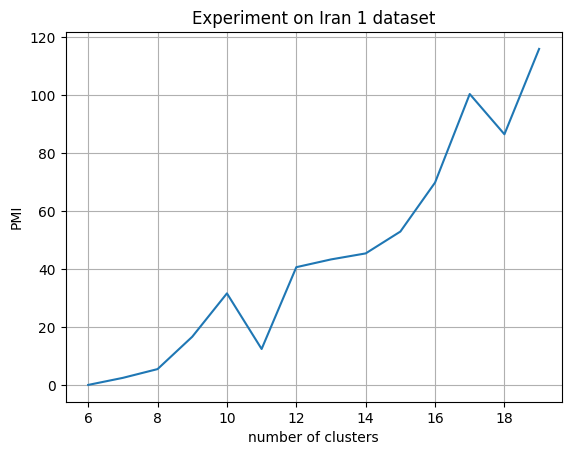

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, pmis)

ax.set(xlabel='number of clusters', ylabel='PMI',
       title='Experiment on Iran 1 dataset')
ax.grid()

plt.show()

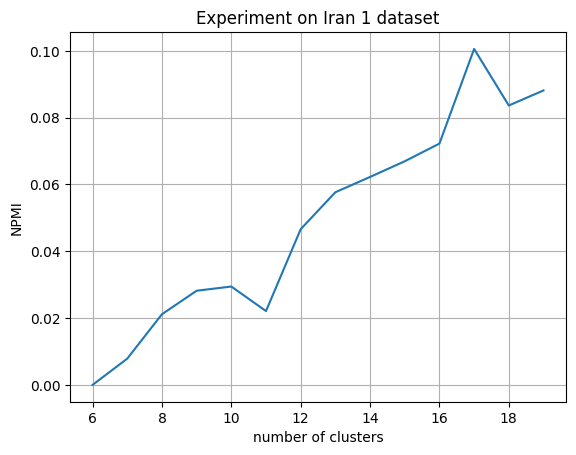

In [ ]:
npmis = []
for i in range(14):
    npmis.append(tables[i]['Avg'][1])
fig, ax = plt.subplots()
ax.plot(x, npmis)

ax.set(xlabel='number of clusters', ylabel='NPMI',
       title='Experiment on Iran 1 dataset')
ax.grid()

plt.show()

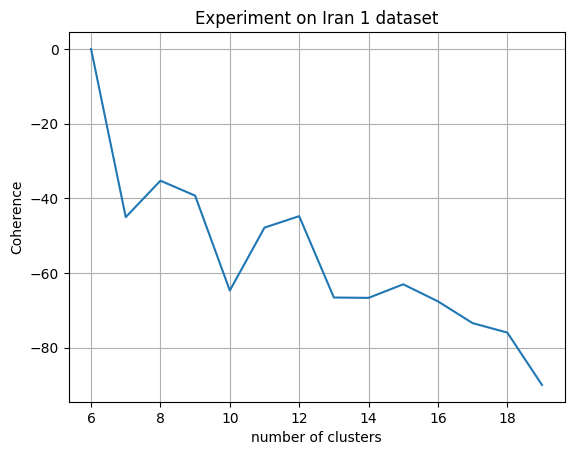

In [ ]:
# previous
cohs = []
for i in range(14):
    cohs.append(tables[i]['Avg'][2])
fig, ax = plt.subplots()
ax.plot(x, cohs)

ax.set(xlabel='number of clusters', ylabel='Coherence',
       title='Experiment on Iran 1 dataset')
ax.grid()

plt.show()

## HDBSCAN

In [ ]:
mtm = MicroTopicModeller()
d = mtm.pipeline(lines)
topics = []
for k, j in d.items():
    if k != 'common_key_words':
        topics.append(j)
res = count_metrics(topics, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)
df = get_result_table(res)

In [ ]:
df

,Metric,Avg,Std
0,PMI,0.0,0.0
1,NPMI,0.0,0.0
2,Coherence,0.0,0.0
3,TFIDF_Coherence,0.0,0.0


#Iran French Dataset

In [ ]:
with open('text_data/iran_fr .txt', 'r') as file:
  lines = file.read()
word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents = prepare_lines(lines)

##KMEANS

In [ ]:
tables = []
for i in range(6, 20):
    mtm = MicroTopicModeller(n_clusters=i)
    d = mtm.pipeline(lines)
    topics = []
    for k, j in d.items():
        if k != 'common_key_words':
            topics.append(j)
    res = count_metrics(topics, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)
    df = get_result_table(res)
    tables.append(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [ ]:
coherences = []
tf_idf_coherences = []
for table in tables:
    coherences.append(table.loc[2, 'Avg'])
    tf_idf_coherences.append(table.loc[3, 'Avg'])
coherences = np.array(coherences)
tf_idf_coherences = np.array(tf_idf_coherences)
print(f'Coherence reaches its maximum {coherences.max()} for {coherences.argmax() + 10} clusters')
print(f'TF-IDF Coherence reaches its maximum {tf_idf_coherences.max()} for {tf_idf_coherences.argmax() + 10} clusters')

Coherence reaches its maximum -12.812262600098697 for 10 clusters
TF-IDF Coherence reaches its maximum 1.8161211546392835 for 14 clusters


In [ ]:
pmis = []
for i in range(14):
    pmis.append(tables[i]['Avg'][0])

In [ ]:
x = np.arange(6, 20)

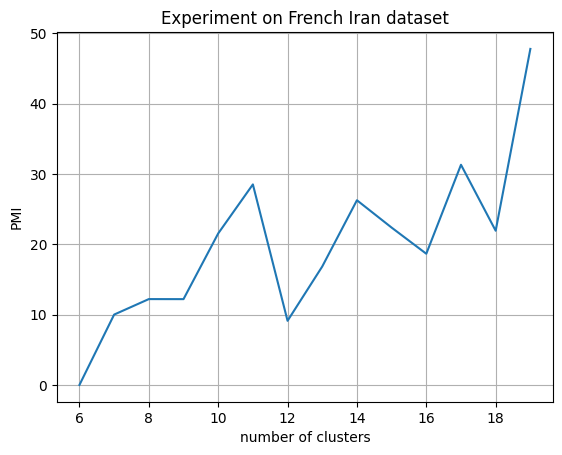

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, pmis)

ax.set(xlabel='number of clusters', ylabel='PMI',
       title='Experiment on French Iran dataset')
ax.grid()

plt.show()

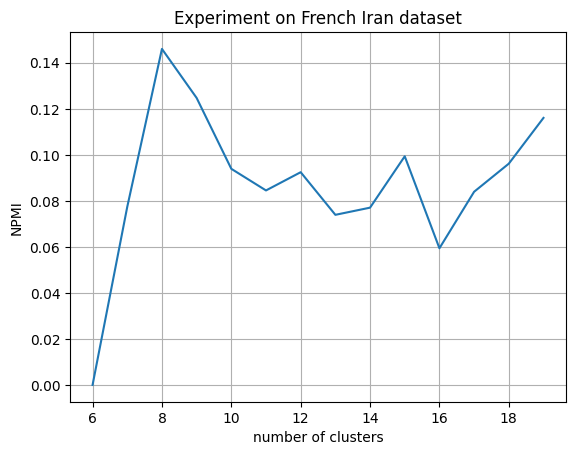

In [ ]:
npmis = []
for i in range(14):
    npmis.append(tables[i]['Avg'][1])
fig, ax = plt.subplots()
ax.plot(x, npmis)

ax.set(xlabel='number of clusters', ylabel='NPMI',
       title='Experiment on French Iran dataset')
ax.grid()

plt.show()

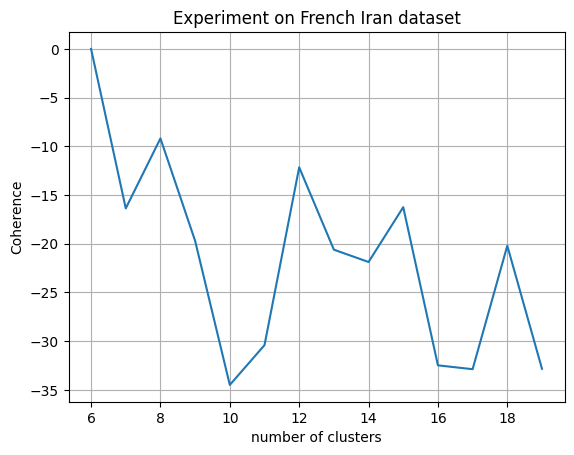

In [ ]:
cohs = []
for i in range(14):
    cohs.append(tables[i]['Avg'][2])
fig, ax = plt.subplots()
ax.plot(x, cohs)

ax.set(xlabel='number of clusters', ylabel='Coherence',
       title='Experiment on French Iran dataset')
ax.grid()

plt.show()

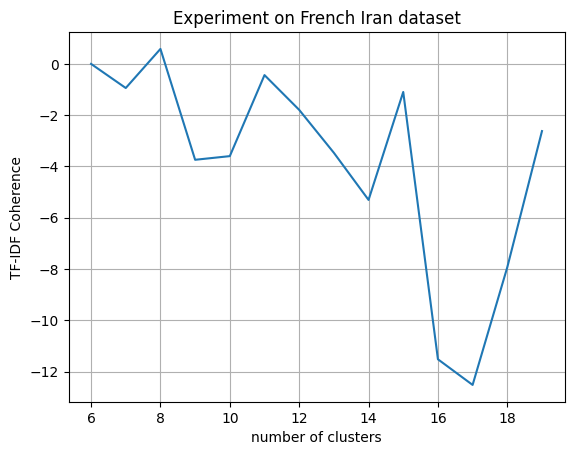

In [ ]:
tcohs = []
for i in range(14):
    tcohs.append(tables[i]['Avg'][3])
fig, ax = plt.subplots()
ax.plot(x, tcohs)

ax.set(xlabel='number of clusters', ylabel='TF-IDF Coherence',
       title='Experiment on French Iran dataset')
ax.grid()

plt.show()

## HDBSCAN

In [ ]:
mtm = MicroTopicModeller()
d = mtm.pipeline(lines)
topics = []
for k, j in d.items():
    if k != 'common_key_words':
        topics.append(j)
res = count_metrics(topics, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)
df = get_result_table(res)

In [ ]:
df

,Metric,Avg,Std
0,PMI,11.937397,21.164478
1,NPMI,0.047876,0.058238
2,Coherence,-16.418602,24.463355
3,TFIDF_Coherence,-5.734328,7.122907


#Coronavirus 1 Dataset

In [ ]:
with open('text_data/coronavirus.txt', 'r') as file:
  lines = file.read()
word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents = prepare_lines(lines)

##KMEANS

In [ ]:
tables = []
for i in range(6, 20):
    mtm = MicroTopicModeller(n_clusters=i)
    d = mtm.pipeline(lines)
    topics = []
    for k, j in d.items():
        if k != 'common_key_words':
            topics.append(j)
    res = count_metrics(topics, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)
    df = get_result_table(res)
    tables.append(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [ ]:
pmis = []
for i in range(14):
    pmis.append(tables[i]['Avg'][0])

In [ ]:
x = np.arange(6, 20)

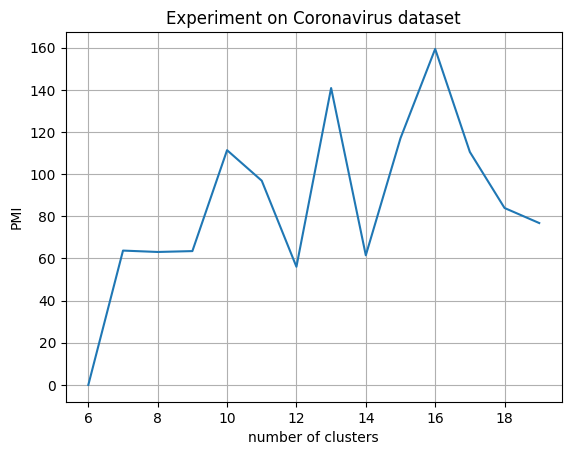

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, pmis)

ax.set(xlabel='number of clusters', ylabel='PMI',
       title='Experiment on Coronavirus dataset')
ax.grid()

plt.show()

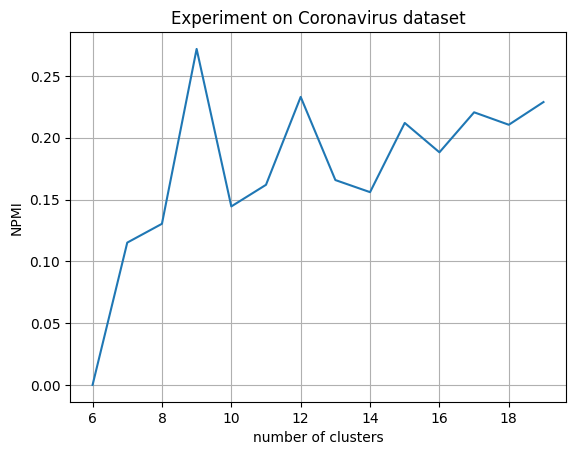

In [ ]:
npmis = []
for i in range(14):
    npmis.append(tables[i]['Avg'][1])
fig, ax = plt.subplots()
ax.plot(x, npmis)

ax.set(xlabel='number of clusters', ylabel='NPMI',
       title='Experiment on Coronavirus dataset')
ax.grid()

plt.show()

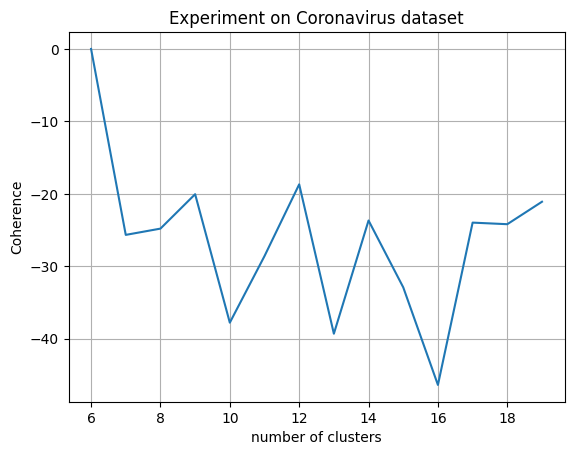

In [ ]:
cohs = []
for i in range(14):
    cohs.append(tables[i]['Avg'][2])
fig, ax = plt.subplots()
ax.plot(x, cohs)

ax.set(xlabel='number of clusters', ylabel='Coherence',
       title='Experiment on Coronavirus dataset')
ax.grid()

plt.show()

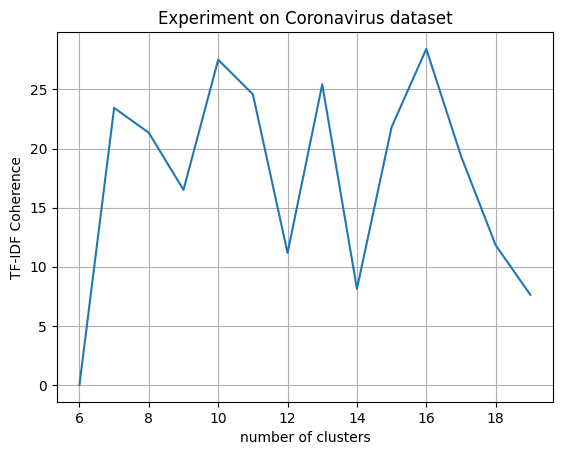

In [ ]:
tcohs = []
for i in range(14):
    tcohs.append(tables[i]['Avg'][3])
fig, ax = plt.subplots()
ax.plot(x, tcohs)

ax.set(xlabel='number of clusters', ylabel='TF-IDF Coherence',
       title='Experiment on Coronavirus dataset')
ax.grid()

plt.show()

In [ ]:
#get_result_table(iran_1)

In [ ]:
#iran_bertopic = count_metrics(bertopic_results[1:], word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)

In [ ]:
#get_result_table(iran_bertopic)

## HDBSCAN

In [ ]:
mtm = MicroTopicModeller()
d = mtm.pipeline(lines)
topics = []
for k, j in d.items():
    if k != 'common_key_words':
        topics.append(j)
res = count_metrics(topics, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)
df = get_result_table(res)

In [ ]:
df

,Metric,Avg,Std
0,PMI,26.593812,17.368686
1,NPMI,0.147683,0.094487
2,Coherence,-15.540305,11.617899
3,TFIDF_Coherence,6.499869,7.509959


#French Coronavirus Dataset

In [ ]:
with open('text_data/french_coronavirus.txt', 'r') as file:
  lines = file.read()
word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents = prepare_lines(lines)

##KMEANS

In [ ]:
tables = []
for i in range(6, 20):
    mtm = MicroTopicModeller(n_clusters=i)
    d = mtm.pipeline(lines)
    topics = []
    for k, j in d.items():
        if k != 'common_key_words':
            topics.append(j)
    res = count_metrics(topics, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)
    df = get_result_table(res)
    tables.append(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [ ]:
coherences = []
tf_idf_coherences = []
for table in tables:
    coherences.append(table.loc[2, 'Avg'])
    tf_idf_coherences.append(table.loc[3, 'Avg'])
coherences = np.array(coherences)
tf_idf_coherences = np.array(tf_idf_coherences)
print(f'Coherence reaches its maximum {coherences.max()} for {coherences.argmax() + 10} clusters')
print(f'TF-IDF Coherence reaches its maximum {tf_idf_coherences.max()} for {tf_idf_coherences.argmax() + 10} clusters')

In [ ]:
pmis = []
for i in range(14):
    pmis.append(tables[i]['Avg'][0])

In [ ]:
x = np.arange(6, 20)

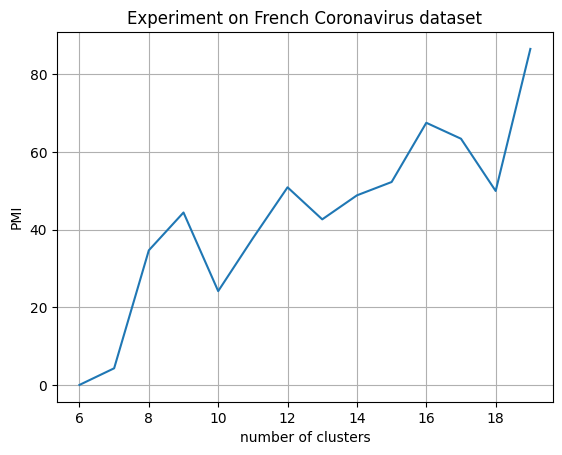

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, pmis)

ax.set(xlabel='number of clusters', ylabel='PMI',
       title='Experiment on French Coronavirus dataset')
ax.grid()

plt.show()

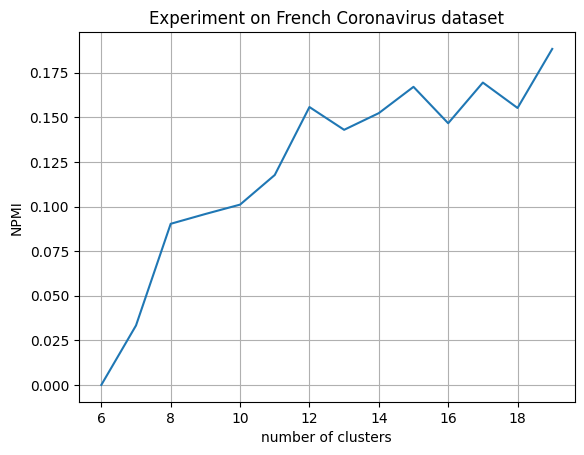

In [ ]:
npmis = []
for i in range(14):
    npmis.append(tables[i]['Avg'][1])
fig, ax = plt.subplots()
ax.plot(x, npmis)

ax.set(xlabel='number of clusters', ylabel='NPMI',
       title='Experiment on French Coronavirus dataset')
ax.grid()

plt.show()

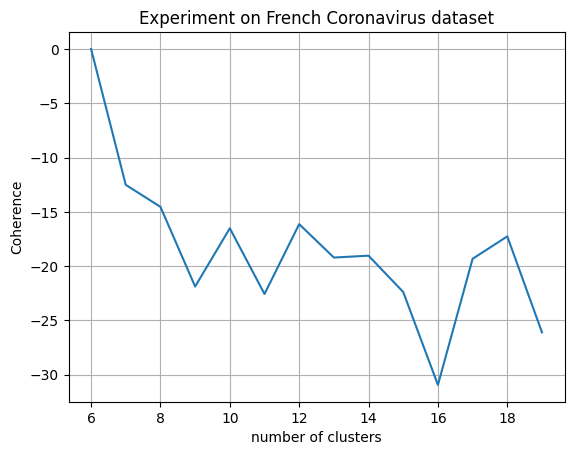

In [ ]:
cohs = []
for i in range(14):
    cohs.append(tables[i]['Avg'][2])
fig, ax = plt.subplots()
ax.plot(x, cohs)

ax.set(xlabel='number of clusters', ylabel='Coherence',
       title='Experiment on French Coronavirus dataset')
ax.grid()

plt.show()

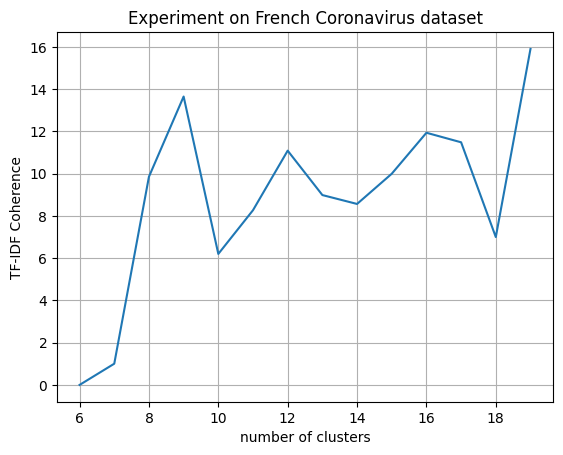

In [ ]:
tcohs = []
for i in range(14):
    tcohs.append(tables[i]['Avg'][3])
fig, ax = plt.subplots()
ax.plot(x, tcohs)

ax.set(xlabel='number of clusters', ylabel='TF-IDF Coherence',
       title='Experiment on French Coronavirus dataset')
ax.grid()

plt.show()

In [ ]:
#get_result_table(iran_1)

In [ ]:
#iran_bertopic = count_metrics(bertopic_results[1:], word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)

In [ ]:
#get_result_table(iran_bertopic)

## HDBSCAN

In [ ]:
mtm = MicroTopicModeller()
d = mtm.pipeline(lines)
topics = []
for k, j in d.items():
    if k != 'common_key_words':
        topics.append(j)
res = count_metrics(topics, word_embedding, tfidf_matrix_transpose, vocabulary, word_frequency, word_frequency_in_documents)
df = get_result_table(res)

In [ ]:
df

,Metric,Avg,Std
0,PMI,8.085532,6.874598
1,NPMI,0.056476,0.035164
2,Coherence,-13.219530,8.425275
3,TFIDF_Coherence,4.829711,6.437604
